## 概要
ネガティブポジティブの判定は比較的容易であるが、ネガティブポジティブそれぞれの中でさらに2つのクラスがあるのが難しさの要因である
そこで、先にポジティブ、ニュートラル、ネガティブの3クラスに分類するモデルを作成し、ポジティブ、ネガティブについてはさらに2クラスに分類するモデルを作ることで解決を図る

# 準備

In [18]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np 

%matplotlib inline
pd.options.display.max_columns = 32

In [19]:
PROJECT_ROOT_PATH = "../../"

datapath = PROJECT_ROOT_PATH + "lab_competition/data/"
outpath = PROJECT_ROOT_PATH + "lab_competition/output/01/"

# sudachiの小さい辞書をインポート
!pip install pyproject-toml
!pip install sudachipy sudachidict_full
!pip install scikit-learn

import numpy as np
import collections


In [20]:
# データ読み込み
train_3class_df = pd.read_csv(datapath + "train_3class.csv")
print(train_3class_df.head())

   3class                                               text
0       0                     ぼけっとしてたらこんな時間。チャリあるから食べにでたいのに…
1       1  今日の月も白くて明るい。昨日より雲が少なくてキレイな〜 と立ち止まる帰り道。チャリなし生活も...
2       0                 早寝するつもりが飲み物がなくなりコンビニへ。ん、今日、風が涼しいな。
3       0                                           眠い、眠れない。
4       0    ただいま〜 って新体操してるやん!外食する気満々で家に何もないのに!テレビから離れられない…!


In [21]:
# データ読み込み
dev_3class_df = pd.read_csv(datapath + "dev_3class.csv")
print(dev_3class_df.head())

   3class                                       text
0       0                    建設中の建物の利用目的も変更になるだろうなあ。
1      -1       演劇とかも同時並行でやっている。演劇の危機にどう思ってるか知りたかった。
2      -1     犬夜叉には腐女子っていないのかな？というかあの漫画はＮＬ向けの漫画なのかも。
3       0  話を続けるための子どもって感じかな。でも、それって簡単にやってはいけない気もする。
4      -1                  今、製作中の劇場版が子どもとかだったらどうしよう。


In [22]:
test_df = pd.read_csv(datapath+"step_estimator_tmp.csv")
test_text = test_df["text"].tolist()

In [23]:
dev_df = pd.read_csv(datapath+"step_estimator_dev_tmp.csv")

In [24]:
train_3class_label = train_3class_df["3class"].values.tolist()
train_3class_text = train_3class_df["text"].values.tolist()
dev_3class_label = dev_3class_df["3class"].values.tolist()
dev_3class_text = dev_3class_df["text"].values.tolist()

In [25]:
import re

def text_cleaning_re(textlist):
    result = []
    for l in textlist:
        tmp = re.sub(r'ww+','ww',l)
        result.append(tmp)
    return result

train_3class_text = text_cleaning_re(train_3class_text)
dev_3class_text = text_cleaning_re(dev_3class_text)
test_text = text_cleaning_re(test_text)

In [26]:
from sudachipy import tokenizer
from sudachipy import dictionary
from itertools import chain
import re

tokenizer_obj = dictionary.Dictionary(dict="full").create()
mode = tokenizer.Tokenizer.SplitMode.C

# 前処理
def text_cleaning(textlist, mode, clear_part_of_speech_list, stopword_list):
    morphemelist = [tokenizer_obj.tokenize(text, mode) for text in textlist]
    result = []
    for morpheme in morphemelist:
        words = []
        for word in morpheme:
            if word.part_of_speech()[0] not in clear_part_of_speech_list[0]:
                if word.part_of_speech()[1] not in clear_part_of_speech_list[1]:
                    if word.normalized_form() not in stopword_list:
                        words.append(word.normalized_form())
        result.append(" ".join(words))
    return result

In [27]:
# 出現頻度が少ない単語をstopwordとする
def stopwords_occur(textlist, threshold):
    morphemelist = [tokenizer_obj.tokenize(text, mode) for text in textlist]
    words = []
    for morpheme in morphemelist:
        for word in morpheme:
            words.append(word.normalized_form())
    dic = collections.Counter(words)
    dic = {key:value for key, value in dic.items() if value<= threshold}
    return list(dic.keys())

clear_part_of_speech_list = [["助詞", "助動詞"],["数詞"]]

with open(datapath + "stopwords.txt") as f:
    stopword_list = f.read().splitlines()

stopword_occur = stopwords_occur(train_3class_text, 2)

stopword_list.extend(stopword_occur)
print(stopword_list)

train_3class_data = text_cleaning(train_3class_text, mode, clear_part_of_speech_list, stopword_list)
dev_3class_deta = text_cleaning(dev_3class_text, mode, clear_part_of_speech_list, stopword_list)
test_data = text_cleaning(test_text, mode, clear_part_of_speech_list, stopword_list)

['。', '、', '.', '為る', '成る', '居る', 'とこ', ':', '/', '_', '-', '〜', '(', ')', '私', '御', '」', '「', '人', '物', 'ー', '言う', 'こと', '見る', '行く', '・', 'さん', 'ちゃん', 'そう', 'よう', ';', '`', '分', '今', '今日', '日', '有る', '又', '来る', '思う', '此の', '時', 'あそこ', 'あたり', 'あちら', 'あっち', 'あと', 'あな', 'あなた', 'あれ', 'いくつ', 'いつ', 'いま', 'いや', 'いろいろ', 'うち', 'おおまか', 'おまえ', 'おれ', 'がい', 'かく', 'かたち', 'かやの', 'から', 'がら', 'きた', 'くせ', 'ここ', 'こっち', 'こと', 'ごと', 'こちら', 'ごっちゃ', 'これ', 'これら', 'ごろ', 'さまざま', 'さらい', 'さん', 'しかた', 'しよう', 'すか', 'ずつ', 'すね', 'すべて', 'ぜんぶ', 'そう', 'そこ', 'そちら', 'そっち', 'そで', 'それ', 'それぞれ', 'それなり', 'たくさん', 'たち', 'たび', 'ため', 'だめ', 'ちゃ', 'ちゃん', 'てん', 'とおり', 'とき', 'どこ', 'どこか', 'ところ', 'どちら', 'どっか', 'どっち', 'どれ', 'なか', 'なかば', 'なに', 'など', 'なん', 'はじめ', 'はず', 'はるか', 'ひと', 'ひとつ', 'ふく', 'ぶり', 'べつ', 'へん', 'ぺん', 'ほう', 'ほか', 'まさ', 'まし', 'まとも', 'まま', 'みたい', 'みつ', 'みなさん', 'みんな', 'もと', 'もの', 'もん', 'やつ', 'よう', 'よそ', 'わけ', 'わたし', 'ハイ', '上', '中', '下', '字', '年', '月', '日', '時', '分', '秒', '週', '火', '水', '木', '金', '土', '国', '都', '道', '府', '県'

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range=(1,1))
train_3class_tfidf = vectorizer.fit_transform(train_3class_data)
dev_3class_tfidf = vectorizer.transform(dev_3class_deta)
test_tfidf = vectorizer.transform(test_data)

train_3class_vec = train_3class_tfidf.toarray()
dev_3class_vec = dev_3class_tfidf.toarray()
test_vec = test_tfidf.toarray()

print("train = " + str(train_3class_vec.shape))
print("trainlabel = " + str(len(train_3class_label)))
print("dev = " + str(dev_3class_vec.shape))
print("devlabel = " + str(len(dev_3class_label)))
print("test = " + str(test_vec.shape))

train = (30000, 9729)
trainlabel = 30000
dev = (2500, 9729)
devlabel = 2500
test = (2500, 9729)


# LightGBM

In [29]:
def float_to_bin(list, threshold):
    result = []
    for num in list:
        if num > threshold:
            result.append(-1)
        else:
            result.append(-2)
    return result

Training until validation scores don't improve for 1 rounds
Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 1.0003
param = 30 report start
正確率 = 0.510 k = 0.313
              precision    recall  f1-score   support

          -1       0.52      0.36      0.43       725
           0       0.33      0.27      0.30       647
           1       0.57      0.74      0.65      1128

    accuracy                           0.51      2500
   macro avg       0.47      0.46      0.46      2500
weighted avg       0.49      0.51      0.49      2500



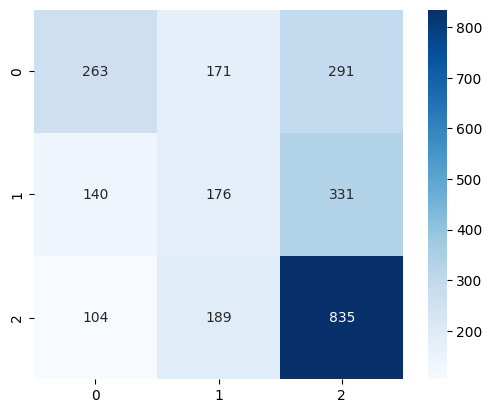

param = 30 report end
Training until validation scores don't improve for 1 rounds
Early stopping, best iteration is:
[47]	valid_0's multi_logloss: 0.9944
param = 40 report start
正確率 = 0.511 k = 0.340
              precision    recall  f1-score   support

          -1       0.52      0.40      0.45       725
           0       0.32      0.30      0.31       647
           1       0.59      0.70      0.64      1128

    accuracy                           0.51      2500
   macro avg       0.48      0.47      0.47      2500
weighted avg       0.50      0.51      0.50      2500



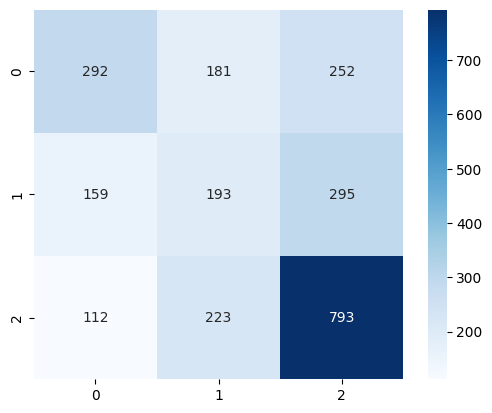

param = 40 report end
Training until validation scores don't improve for 1 rounds
Early stopping, best iteration is:
[43]	valid_0's multi_logloss: 0.99392
param = 50 report start
正確率 = 0.508 k = 0.330
              precision    recall  f1-score   support

          -1       0.50      0.40      0.45       725
           0       0.33      0.30      0.31       647
           1       0.59      0.70      0.64      1128

    accuracy                           0.51      2500
   macro avg       0.47      0.47      0.47      2500
weighted avg       0.50      0.51      0.50      2500



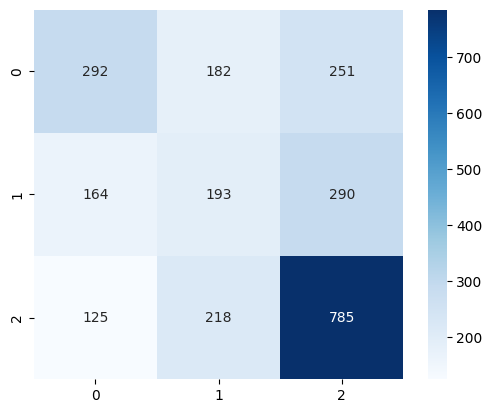

param = 50 report end
Training until validation scores don't improve for 1 rounds
Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.993003
param = 60 report start
正確率 = 0.507 k = 0.337
              precision    recall  f1-score   support

          -1       0.50      0.41      0.45       725
           0       0.32      0.29      0.30       647
           1       0.60      0.69      0.64      1128

    accuracy                           0.51      2500
   macro avg       0.47      0.46      0.47      2500
weighted avg       0.50      0.51      0.50      2500



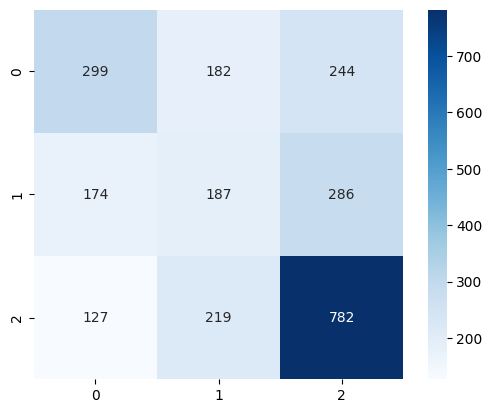

param = 60 report end
Training until validation scores don't improve for 1 rounds
Early stopping, best iteration is:
[33]	valid_0's multi_logloss: 0.993192
param = 70 report start
正確率 = 0.506 k = 0.335
              precision    recall  f1-score   support

          -1       0.50      0.42      0.45       725
           0       0.32      0.29      0.30       647
           1       0.59      0.69      0.64      1128

    accuracy                           0.51      2500
   macro avg       0.47      0.46      0.46      2500
weighted avg       0.49      0.51      0.50      2500



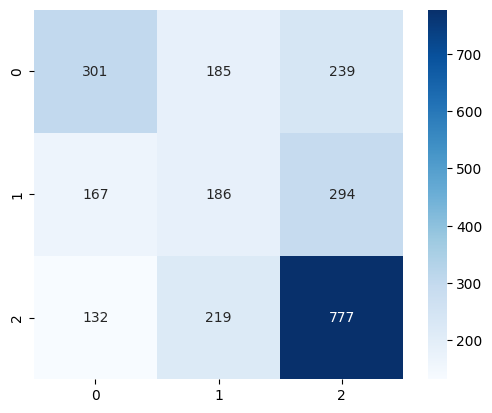

param = 70 report end
タスク終了　best_c = 40 acc = 0.5112


In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_sample_weight
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score
import lightgbm as lgb

tmp_train_label = [i+1 for i in train_3class_label]
train_set = lgb.Dataset(train_3class_vec, tmp_train_label)
valid_set = lgb.Dataset(dev_3class_vec, [i+1 for i in dev_3class_label])

param_list = [30,40,50,60,70]
best_c = 0
best_c_acc = 0

for param in param_list:
    lgbparams = {
        'task': 'train',
        "objective": 'multiclass',
        'num_class': 3,
        'metric': 'multi_logloss',
        'num_leaves': param,
        "learning_rate" :0.1,
        'verbose': -1,
        'feature_fraction': 1,
        'bagging_freq': 1,
        "bagging_fraction": 1,
        "lambda_l1":0,
        "random_state":1
    }
    model = lgb.train(
        params = lgbparams,
        train_set = train_set,
        valid_sets = valid_set,
        callbacks=[lgb.early_stopping(stopping_rounds=1, 
                    verbose=True), # early_stopping用コールバック関数
                    lgb.log_evaluation(50)],
        num_boost_round=10000,
    )
    dev_pred = [i-1 for i in np.argmax(model.predict(dev_3class_vec), axis=1)]
    k = cohen_kappa_score(dev_pred, dev_3class_label, weights="quadratic")
    acc = accuracy_score(dev_pred, dev_3class_label)
    conmat = confusion_matrix(dev_3class_label, dev_pred)
    print("param = " + str(param) + " report start")
    print("正確率 = %.3f k = %.3f" % (acc, k))
    print(classification_report(dev_3class_label, dev_pred))
    plt.figure()
    sns.heatmap(conmat, square=True, cbar=True, annot=True, cmap='Blues', fmt='d')
    plt.show()
    print("param = " + str(param) + " report end")
    if acc > best_c_acc:
        best_c_acc = acc
        best_c = param

print("タスク終了　best_c = " + str(best_c) + " acc = " + str(best_c_acc))

# 出力

# テストデータに適用

In [43]:
test_pred = [i-1 for i in np.argmax(model.predict(test_vec), axis=1)]

test_df = pd.read_csv(datapath+"step_estimator_tmp.csv")
test_df["3class_pred"] = test_pred

print(test_df.head(100))

test_df.to_csv(datapath+"step_estimator_tmp.csv", index = False)

                                                 text  negative_pred  \
0               ハッピーセット、またプラレールが始まるからしばらくマックばかりになりそう。             -1   
1                      今日は天気が良いので外出がきもちよいです。秋晴れ良いですね。             -2   
2         あぁ〜そうなんだ。。。 やっぱライブでは芸人みんなわちゃわちゃしてるとこが見たかったな             -1   
3                                      踊り場110話まできたぞこら             -1   
4                                カウコン行かれる方、楽しんで下さい〜！！             -1   
..                                                ...            ...   
95  30分在宅ワーク→30分家事を繰り返してるとあっという間に夜になる。あまり疲労感も無いしおす...             -1   
96                         最近はコンビニで手軽にプロテイントレイニーの時代か…             -1   
97                               今月は3万5千円目標と、やや控えめに設定             -1   
98                           明日から弁当だ。今日は忘れずにおかず買わないと。             -1   
99                 ドットインストールから最近全然やってないね、とかいうメールきてた。汗             -1   

    3class_pred  positive_pred  
0             1              1  
1             1              1  
2             1              2  
3  

# dev出力

In [44]:
dev_pred = [i-1 for i in np.argmax(model.predict(dev_3class_vec), axis=1)]

dev_df = pd.read_csv(datapath+"step_estimator_dev_tmp.csv")
dev_df["3class_pred"] = dev_pred

print(dev_df.head(100))

dev_df.to_csv(datapath+"step_estimator_dev_tmp.csv", index = False)

    data                                               text  negative_pred  \
0    0.0                            建設中の建物の利用目的も変更になるだろうなあ。             -1   
1   -2.0               演劇とかも同時並行でやっている。演劇の危機にどう思ってるか知りたかった。             -1   
2   -1.0             犬夜叉には腐女子っていないのかな？というかあの漫画はＮＬ向けの漫画なのかも。             -1   
3    0.0          話を続けるための子どもって感じかな。でも、それって簡単にやってはいけない気もする。             -1   
4   -1.0                          今、製作中の劇場版が子どもとかだったらどうしよう。             -1   
..   ...                                                ...            ...   
95  -2.0                    ツイッターでは毎日とても細かいことの議論で、みんな哲学してる。             -2   
96  -2.0                                 判断基準は古いか新しいかだけだった。             -1   
97   1.0               アプリが終了らしい。7月末。一度、インストールしてアンインストールした。             -1   
98   2.0                             月曜日が楽しみですね。トレンド入りするかな。             -1   
99   2.0  ほんと、考察がすごい。自分だけではわからなかったこととか多すぎる。他のことにも援用できる。物...             -1   

    3class_pred  positive_pred  
0             1              1